# ***Trabajo Práctico N°2 : Criticas cinematográficas***

**Grupo N°06: Pandatos**

Integrantes:
* Juan Sebastian Makkos.
* Valeria Brzoza.
* Rodolfo Valentin Albornoz Tomé.


Importamos las librerias correspondientes que vamos a utilizar

In [ ]:
##### Librerias principales
import pandas as pd
import numpy as np
from matplotlib.pyplot import xlabel, ylabel
from seaborn import heatmap
from re import sub
import tensorflow as tf

##### Procesamiento de lenguaje natural
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##### Bag of Words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

##### Modelos
from sklearn.pipeline import make_pipeline

### Bayes Naive
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

### XGBoost
from xgboost import XGBClassifier

### Random Forest
from sklearn.ensemble import RandomForestClassifier

### Hibridos
from sklearn.ensemble import VotingClassifier, StackingClassifier

### Redes neuronales
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Conv1D, Reshape, GRU, Flatten, SimpleRNN, SpatialDropout1D, Bidirectional, Dropout, Masking
from keras.models import Sequential

### Otros
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC

##### Metricas y analisis de performance
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, classification_report, make_scorer

##### CV
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

##### Otros
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

#from google.colab import drive
#drive.mount('/content/drive')

Realizamos las instalaciones necesarias

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BigMak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BigMak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BigMak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\BigMak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Importamos los dataset que vamos a utilizar

In [ ]:
ds_criticas_train = pd.read_csv('train.csv')
ds_criticas_test = pd.read_csv('test.csv')
ds_trabajo = ds_criticas_train.copy()
ds_test = ds_criticas_test.copy()

# Análisis exploratorio

Mostramos las primeras 10 filas del dataset

In [ ]:
ds_trabajo.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


Mostramos las últimas 10 filas del dataset

In [ ]:
ds_trabajo.tail(10)

,ID,review_es,sentimiento
49990,49990,"Cojo, cojo, cojo !!!Un festival de 90 minutos ...",negativo
49991,49991,"Les Visiteurs, la primera película sobre los v...",negativo
49992,49992,John Garfield interpreta a un marine que está ...,positivo
49993,49993,Robert Colomb tiene dos trabajos a tiempo comp...,negativo
49994,49994,Esta es tu comedia de chatarra típica. Casi no...,negativo
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo
49999,49999,Nadie espera que las películas de Star Trek se...,negativo


Mostramos el tamaño del dataset

In [ ]:
ds_trabajo.shape

(50000, 3)

Mostramos la info de las columnas del dataset

In [ ]:
ds_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


De lo cual podemos concluir que no hay valores nulos

Algunas cosas extras que notamos de este dataset son las siguientes:

* Algunas reseñas tienen palabras en ingles
* Hay caracteres especiales como @ y *

Estas cosas las tendremos en cuenta en el preprocesamiento


# Preprocesamiento

Procedemos a procesar el texto de cada crítica usando algunas técnicas, como eliminar signos de puntuación, palabras sin carga positiva o negativa, etc.

## Eliminacion de puntuación

Primero, eliminamos algunos caracteres especiales (Excepto algunos que pueden ser importantes, como el punto y la coma)

In [ ]:
def eliminar_caracteres_especiales(oracion):
 return sub(r'[^a-zA-Z0-9ñáéíóú.,!¡¿"*@\s]', '', oracion)

In [ ]:
ds_trabajo['review_es'] = [eliminar_caracteres_especiales(reseña) for reseña in ds_trabajo['review_es']]

## Convertir palabras a minuscula

Convertimos los strings de cada reseña del dataset a minusculas

In [ ]:
def convertir_a_minuscula(oracion):
    oracion_en_minuscula = oracion.lower()
    return oracion_en_minuscula

In [ ]:
ds_trabajo['review_es'] = [convertir_a_minuscula(reseña) for reseña in ds_trabajo['review_es']]

## Eliminación de stop words

Eliminamos ahora las stop words (Palabras que no aportan valor a cada reseña, como proposiciones o palabras sin carga de valor) tanto en ingles como español de cada reseña del dataset

In [ ]:
def remover_stopwords(oracion, idioma):
    stop_words = set(stopwords.words(idioma))
    palabras = word_tokenize(oracion)
    palabras_sin_stopwords = [palabra for palabra in palabras if palabra not in stop_words]
    return ' '.join(palabras_sin_stopwords)

In [ ]:
ds_trabajo['review_es'] = [remover_stopwords(oracion, 'spanish') for oracion in ds_trabajo['review_es']]

In [ ]:
ds_trabajo['review_es'] = [remover_stopwords(oracion, 'english') for oracion in ds_trabajo['review_es']]

## Lemmatization

Hacemos una lemmatization sobre cada palabra de cada reseña usando el WordNetLemmatizer

In [ ]:
def lemmatize(oracion):
    lemmatizer = WordNetLemmatizer()
    palabras = word_tokenize(oracion)
    oracion_lemmatizada = [lemmatizer.lemmatize(palabra) for palabra in palabras]
    return ' '.join(oracion_lemmatizada)

In [ ]:
ds_trabajo['review_es'] = [lemmatize(oracion) for oracion in ds_trabajo['review_es']]

# Modelos

Manipulamos el dataset de trabajo para poder separarlo en 2 partes, un dataset con el atributo a predecir, y un dataset con las criticas

In [ ]:
target = 'sentimiento'

ds_trabajo_x = ds_trabajo['review_es']
ds_trabajo_y = ds_trabajo[target].copy()

A partir del dataset con el target, creamos un arreglo donde cambiamos los 'positivo' por 1 y 'negativo' por 0, para poder hacer predicciones en algunos de los modelos

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(ds_trabajo_y)

In [ ]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

Creamos la funcion para obtener un f1 score personalizado con la etiqueta correcta para predecir correctamente segun el modelo

In [ ]:
def custom_f1_score(y_true, y_pred, pos_label = 1):
  return f1_score(y_true, y_pred, pos_label = pos_label)

f1_bayes = make_scorer(custom_f1_score, pos_label = 'positivo')
f1 = make_scorer(custom_f1_score)

## Bayes Naive

Dividimos el conjunto de datos en train y test

In [ ]:
x_train_bayes, x_test_bayes, y_train_bayes, y_test_bayes = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size = 0.30, random_state = 22, shuffle = True)

### Creacion del modelo

Aplicamos Bag of Words creando instancias de los vectorizer count y tfidf, y a partir de ellos, creamos modelos con MultinomialNB y BernoulliNB. Combinamos todo usando pipelines

In [ ]:
model_multinomial_tfidf = make_pipeline(tfidfVectorizer, MultinomialNB())
model_multinomial_count = make_pipeline(countVectorizer, MultinomialNB())

model_bernoulli_tfidf = make_pipeline(tfidfVectorizer, BernoulliNB())
model_bernoulli_count = make_pipeline(countVectorizer, BernoulliNB())

Entrenamos cada modelo

In [ ]:
model_multinomial_tfidf.fit(x_train_bayes, y_train_bayes)
model_multinomial_count.fit(x_train_bayes, y_train_bayes)

model_bernoulli_tfidf.fit(x_train_bayes, y_train_bayes)
model_bernoulli_count.fit(x_train_bayes, y_train_bayes)

Realizamos las predicciones correspondientes

In [ ]:
y_pred_multinomial_tfidf = model_multinomial_tfidf.predict(x_test_bayes)
y_pred_multinomial_count = model_multinomial_count.predict(x_test_bayes)

y_pred_bernoulli_tfidf = model_bernoulli_tfidf.predict(x_test_bayes)
y_pred_bernoulli_count = model_bernoulli_count.predict(x_test_bayes)

### Optimización de hiperparámetros

Creamos modelos optimizando hiperparametros para cada tipo de modelo

#### TfidfVectorizer y MultinomialNB

In [ ]:
parameters = {'tfidfvectorizer__max_features': (None, 1000, 5000),
              'multinomialnb__alpha': (0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0),
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidfvectorizer__stop_words': [None, 'english'],
}

model_multinomial_tfidf = make_pipeline(tfidfVectorizer, MultinomialNB())
model_multinomial_tfidf_cv = RandomizedSearchCV(model_multinomial_tfidf, parameters, scoring = f1_bayes)
model_multinomial_tfidf_cv.fit(x_train_bayes, y_train_bayes)

print("Mejores hiperparámetros:", model_multinomial_tfidf_cv.best_params_)
print("Puntuación del mejor modelo:", model_multinomial_tfidf_cv.best_score_)

Mejores hiperparámetros: {'tfidfvectorizer__stop_words': 'english', 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__max_features': None, 'multinomialnb__alpha': 0.1}
Puntuación del mejor modelo: 0.8813463338701066


#### CountVectorizer y MultinomialNB

In [ ]:
parameters = {'countvectorizer__max_features': (None, 1000, 5000),
              'multinomialnb__alpha': (0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0),
              'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'countvectorizer__stop_words': [None, 'english'],
}

model_multinomial_count = make_pipeline(countVectorizer, MultinomialNB())
model_multinomial_count_cv = RandomizedSearchCV(model_multinomial_count, parameters, scoring = f1_bayes)
model_multinomial_count_cv.fit(x_train_bayes, y_train_bayes)

print("Mejores hiperparámetros:", model_multinomial_count_cv.best_params_)
print("Puntuación del mejor modelo:", model_multinomial_count_cv.best_score_)

#### TfidfVectorizer y BernoulliNB

In [ ]:
parameters = {'tfidfvectorizer__max_features': (None, 1000, 5000),
              'bernoullinb__alpha': (0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0),
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidfvectorizer__stop_words': [None, 'english'],
}

model_bernoulli_tfidf = make_pipeline(tfidfVectorizer, BernoulliNB())
model_bernoulli_tfidf_cv = RandomizedSearchCV(model_bernoulli_tfidf, parameters, scoring = f1_bayes)
model_bernoulli_tfidf_cv.fit(x_train_bayes, y_train_bayes)

print("Mejores hiperparámetros:", model_bernoulli_tfidf_cv.best_params_)
print("Puntuación del mejor modelo:", model_bernoulli_tfidf_cv.best_score_)

#### CountVectorizer y BernoulliNB

In [ ]:
parameters = {'countvectorizer__max_features': (None, 1000, 5000),
              'bernoullinb__alpha': (0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0),
              'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'countvectorizer__stop_words': [None, 'english'],
}

model_bernoulli_count = make_pipeline(countVectorizer, BernoulliNB())
model_bernoulli_count_cv = RandomizedSearchCV(model_bernoulli_count, parameters, scoring = f1_bayes)
model_bernoulli_count_cv.fit(x_train_bayes, y_train_bayes)

print("Mejores hiperparámetros:", model_bernoulli_count_cv.best_params_)
print("Puntuación del mejor modelo:", model_bernoulli_count_cv.best_score_)

#### Prediccion

Realizamos la predicción correspondiente

In [ ]:
y_pred_bayes_cv = model_multinomial_tfidf_cv.predict(x_test_bayes)

## XGBoost

Dividimos el conjunto de datos en train y test

In [ ]:
x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = train_test_split(ds_trabajo_x, y_encoded, test_size = 0.3, random_state = 42)

Aplicamos Bag of Words creando instancias de los vectorizer count y tfidf, y aplicandolos sobre los conjuntos de datos de train y test

In [ ]:
x_train_tfidf_xgb = tfidfVectorizer.fit_transform(x_train_xgb)
x_test_tfidf_xgb = tfidfVectorizer.transform(x_test_xgb)

x_train_count_xgb = countVectorizer.fit_transform(x_train_xgb)
x_test_count_xgb = countVectorizer.transform(x_test_xgb)

### Creación del modelo

Creamos el modelo XGBoost y lo entrenamos

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train_count_xgb, y_train_xgb)

Realizamos la predicción correspondiente

In [ ]:
y_pred_xgb = xgb_model.predict(x_test_count_xgb)

### Optimización de hiperparámetros

Creamos modelos optimizando hiperparametros para cada tipo de modelo

#### TfidfVectorizer

In [ ]:
parameters = {
    'tfidfvectorizer__max_features': [None, 1000, 5000],
    'tfidfvectorizer__max_df': [0.85, 0.9, 0.95],
    'tfidfvectorizer__min_df': [0.05, 0.07, 0.1],
    'xgbclassifier__n_estimators': [100, 500, 1000],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001]
}

model_tfidf = make_pipeline(tfidfVectorizer, XGBClassifier())
model_xgb_tfidf_cv = RandomizedSearchCV(model_tfidf, parameters, scoring = f1)
model_xgb_tfidf_cv.fit(x_train_xgb, y_train_xgb)

print("Mejores hiperparámetros:", model_xgb_tfidf_cv.best_params_)
print("Puntuación del mejor modelo:", model_xgb_tfidf_cv.best_score_)

#### CountVectorizer

In [ ]:
parameters = {
    'countvectorizer__max_features': [None, 1000, 5000],
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'xgbclassifier__n_estimators': [100, 500, 1000],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001]
}

model_count = make_pipeline(countVectorizer, XGBClassifier())
model_xgb_count_cv = RandomizedSearchCV(model_count, parameters, scoring = f1)
model_xgb_count_cv.fit(x_train_xgb, y_train_xgb)

print("Mejores hiperparámetros:", model_xgb_count_cv.best_params_)
print("Puntuación del mejor modelo:", model_xgb_count_cv.best_score_)

#### Predicción

Realizamos la predicción correspondiente

In [ ]:
y_pred_xgb_cv = model_xgb_tfidf_cv.best_estimator_.predict(x_test_xgb)

## Random Forest

Dividimos el conjunto de datos en train y test

In [ ]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(ds_trabajo_x, y_encoded, test_size = 0.3, random_state = 42)

Aplicamos Bag of Words creando instancias de los vectorizer count y tfidf, y aplicandolos sobre los conjuntos de datos de train y test

In [ ]:
x_train_tfidf_rf = tfidfVectorizer.fit_transform(x_train_rf)
x_test_tfidf_rf = tfidfVectorizer.transform(x_test_rf)

x_train_count_rf = countVectorizer.fit_transform(x_train_rf)
x_test_count_rf = countVectorizer.transform(x_test_rf)

### Creación del modelo

Creamos el modelo Random Forest y lo entrenamos

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_tfidf_rf, y_train_rf)

Realizamos la predicción correspondiente

In [ ]:
y_pred_rf = rf_model.predict(x_test_tfidf_rf)

### Optimización de hiperparámetros

Creamos modelos optimizando hiperparametros para cada tipo de modelo

#### TfidfVectorizer

In [ ]:
parameters = {
    'tfidfvectorizer__max_features': [None, 1000, 5000],
    'tfidfvectorizer__max_df': [0.85, 0.9, 0.95],
    'tfidfvectorizer__min_df': [0.05, 0.07, 0.1],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [3, 5, 7],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['auto', 'sqrt']
}

model_tfidf = make_pipeline(tfidfVectorizer, RandomForestClassifier())
model_rf_tfidf_cv = RandomizedSearchCV(model_tfidf, parameters, scoring = f1)
model_rf_tfidf_cv.fit(x_train_rf, y_train_rf)

print("Mejores hiperparámetros:", model_rf_tfidf_cv.best_params_)
print("Puntuación del mejor modelo:", model_rf_tfidf_cv.best_score_)

Mejores hiperparámetros: {'tfidfvectorizer__min_df': 0.05, 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__max_df': 0.95, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None}
Puntuación del mejor modelo: 0.7704581538329681


#### CountVectorizer

In [ ]:
parameters = {
    'countvectorizer__max_features': [None, 1000, 5000],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [3, 5, 7],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['auto', 'sqrt']
}

model_count = make_pipeline(countVectorizer, RandomForestClassifier())
model_rf_count_cv = RandomizedSearchCV(model_count, parameters, scoring = f1)
model_rf_count_cv.fit(x_train_rf, y_train_rf)

print("Mejores hiperparámetros:", model_rf_count_cv.best_params_)
print("Puntuación del mejor modelo:", model_rf_count_cv.best_score_)

#### Predicción

Realizamos la predicción correspondiente

In [ ]:
y_pred_rf_cv = model_rf_tfidf_cv.predict(x_test_rf)

## Redes neuronales

Establecemos los hiperparámetros generales que vamos a usar en los modelos de cada arquitectura

In [ ]:
epochs = 3
batch_size = 32
num_words = 10000
max_sequence_length = 2
padding_type = "post"
trunction_type = "post"

Establecemos los hiperparámetros para las capas del tipo Dense

In [ ]:
n_dense = 64

Establecemos los hiperparametros para las capas del tipo Dropout

In [ ]:
dropout = 0.5

Establecemos los hiperparámetros para las capas del tipo Embedding

In [ ]:
embedding_dim = 100

Establecemos los hiperparámetros para las capas del tipo SpatialDropout1D

In [ ]:
drop_embed = 0.2

Establecemos los hiperparámetros para las capas del tipo RNN

In [ ]:
n_rnn = 256
drop_rnn = 0.2

Establecemos los hiperparámetros para las capas del tipo LSTM

In [ ]:
lstm_units = 176

Establecemos los hiperparámetros para las capas del tipo Conv1D

In [ ]:
filters = 64
kernel_size = 2

Creamos la funcion personalizada para calcular el score f1  y utilizarlo al compilar cada modelo

In [ ]:
def f1_score_rn(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.round(K.flatten(y_pred))

    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    predicted_positives = K.sum(y_pred)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

Realizamos la division en train y test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, y_encoded, test_size = 0.2, random_state = 42)

Creamos el tokenizer para transformar los datos de train y test

In [ ]:
tokenizer = Tokenizer(num_words=None,
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')

tokenizer.fit_on_texts(x_train)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

train_padded_sequences = pad_sequences(x_train_sequences, maxlen = max_sequence_length, padding = padding_type, truncating = trunction_type)
test_padded_sequences = pad_sequences(x_test_sequences, maxlen = max_sequence_length, padding = padding_type, truncating = trunction_type)

Por ultimo, establecemos el tamaño del vocabulario

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

Ahora, procedemos a crear modelos con diferentes arquitecturas segun el tipo de capas que usamos dentro de los modelos de red neuronal

### Arquitectura simple con Embedding

Creamos el modelo para una arquitectura solo con capa embedding, flatten y capas densas

In [ ]:
model_embedding = Sequential()
model_embedding.add(Embedding(vocab_size, embedding_dim, input_length = max_sequence_length))
model_embedding.add(Flatten())
model_embedding.add(Dense(2, activation = 'relu'))
model_embedding.add(Dense(1, activation = 'sigmoid'))

Compilamos el modelo usando adam como optimizador y binary_crossentropy como funcion de pérdida, optimizando la métrica f1, hacemos fit sobre el modelo, y evaluamos el modelo

In [ ]:
model_embedding.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_score_rn])

model_embedding.summary()

history = model_embedding.fit(train_padded_sequences, y_train, epochs = epochs, batch_size = batch_size, validation_data = [test_padded_sequences, y_test])

model_embedding.evaluate(test_padded_sequences, y_test)

### Arquitectura con capas RNN

Creamos el modelo para una arquitectura solo con capa embedding y capa RNN simple

In [ ]:
model_RNN = Sequential()
model_RNN.add(Embedding(vocab_size, embedding_dim, input_length = max_sequence_length))
model_RNN.add(SimpleRNN(units = 64))
model_RNN.add(Dense(units = 1, activation = 'sigmoid'))

Compilamos el modelo usando adam como optimizador y binary_crossentropy como funcion de pérdida, optimizando la métrica f1, hacemos fit sobre el modelo, y evaluamos el modelo

In [ ]:
model_RNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_score_rn])

model_RNN.summary()

history = model_RNN.fit(train_padded_sequences, y_train, epochs = epochs, batch_size = batch_size, validation_data = [test_padded_sequences, y_test])

model_RNN.evaluate(test_padded_sequences, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2, 100)            25447800  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,458,425
Trainable params: 25,458,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1250/1250 [==============================] - 334s 267ms/step - loss: 0.6552 - f1_score_rn: 0.5816 - val_loss: 0.6426 - val_f1_score_rn: 0.6252
Epoch 2/3
1250/1250 [==============================] - 328s 263ms/step - loss: 0.5561 - f1_score_rn: 0.7022 - val_loss: 0.6668 - val_f1_score_rn: 0.6169


[0.7137771844863892, 0.6131457686424255]

### Arquitectura con capas LSTM

Creamos el modelo para una arquitectura solo con capa embedding y capa LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(units = 64))
model_lstm.add(Dense(1, activation='softmax'))

Compilamos el modelo usando adam como optimizador y binary_crossentropy como funcion de pérdida, optimizando la métrica f1, hacemos fit sobre el modelo, y evaluamos el modelo

In [ ]:
model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_score_rn])

model_lstm.summary()

history = model_lstm.fit(train_padded_sequences, y_train, epochs = epochs, batch_size = batch_size, validation_data = [test_padded_sequences, y_test])

model_lstm.evaluate(test_padded_sequences, y_test)

### Arquitectura con capas GRU

Creamos el modelo para una arquitectura solo con capa embedding y capa GRU

In [ ]:
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model_GRU.add(GRU(units = 100))
model_GRU.add(Dense(units = 1, activation='sigmoid'))

Compilamos el modelo usando adam como optimizador y binary_crossentropy como funcion de pérdida, optimizando la métrica f1, hacemos fit sobre el modelo, y evaluamos el modelo

In [ ]:
model_GRU.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_score_rn])

model_GRU.summary()

history = model_GRU.fit(train_padded_sequences, y_train, epochs = epochs, batch_size = batch_size, validation_data = [test_padded_sequences, y_test])

model_GRU.evaluate(test_padded_sequences, y_test)

### Arquitectura con capas CNN

Creamos el modelo para una arquitectura con capa embedding, Reshape, Conv1D, Pooling y Dense

In [ ]:
model_CNN = Sequential()
model_CNN.add(Embedding(vocab_size, embedding_dim, input_length = max_sequence_length))
model_CNN.add(Reshape((max_sequence_length, embedding_dim)))
model_CNN.add(Conv1D(filters, kernel_size, activation = 'relu'))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(units = 1, activation = 'sigmoid'))

Compilamos el modelo usando adam como optimizador y binary_crossentropy como funcion de pérdida, optimizando la métrica f1, hacemos fit sobre el modelo, y evaluamos el modelo

In [ ]:
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_rn])

model_CNN.summary()

history = model_CNN.fit(train_padded_sequences, y_train, epochs = epochs, batch_size = batch_size, validation_data = [test_padded_sequences, y_test])

model_CNN.evaluate(test_padded_sequences, y_test)

## Ensamble Hibrido Voting

Dividimos el conjunto de datos en train y test

In [ ]:
x_train_voting, x_test_voting, y_train_voting, y_test_voting = train_test_split(ds_trabajo_x, y_encoded, test_size = 0.3, random_state = 42)

Transformamos los datos de train y test

In [ ]:
x_train_tfidf_voting = tfidfVectorizer.fit_transform(x_train_voting)
x_test_tfidf_voting = tfidfVectorizer.transform(x_test_voting)

Creamos instancias de modelos que vamos a usar en el voting, y entrenamos el modelo del voting

In [ ]:
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
bayes_naive = MultinomialNB()

estimators_models = [('nb', bayes_naive), ('rf', rnd_clf), ('knn', knn_clf)]
vot_clf = VotingClassifier(estimators = estimators_models, voting = 'soft')
model_voting = vot_clf.fit(x_train_tfidf_voting, y_train_voting)

Realizamos la predicción correspondiente

In [ ]:
y_pred_voting = vot_clf.predict(x_test_tfidf_voting)

# Performance de Modelos

Creamos la función para plotear la matriz de confusión

In [ ]:
def matriz_de_confusion(y_test, y_pred):

  tabla = confusion_matrix(y_test, y_pred)

  heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g')
  xlabel('Predicted')
  ylabel('True')

Creamos la función para imprimir las métricas en el conjunto de evaluación

In [ ]:
def metricas_evaluacion(y_test, y_pred, pos_label = 1):
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred, pos_label = 1)
  f1 = f1_score(y_test, y_pred, pos_label = 1)

  print("Accuracy: "+ str(accuracy))
  print("Recall: "+ str(recall))
  print("f1 score: "+ str(f1))

Creamos la función para mostrar el reporte del valor de las métricas para el conjunto de test

In [ ]:
def valor_metricas_test(y_test, y_pred):
  print(classification_report(y_test, y_pred))

Creamos la función para mostrar el reporte del valor de las métricas para el conjunto de training

In [ ]:
def valor_metricas_train(y_train, x_train, modelo):
  print(classification_report(y_train, modelo.predict(x_train)))

## Bayes Naive

Matriz de confusion del modelo

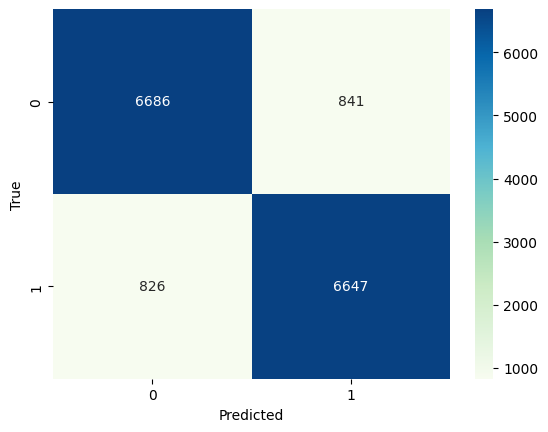

In [ ]:
matriz_de_confusion(y_test_bayes, y_pred_bayes_cv)

Métricas en el conjunto de evaluación del modelo

In [ ]:
metricas_evaluacion(y_test_bayes, y_pred_bayes_cv, 'positivo')

Accuracy: 0.8888666666666667
Recall: 0.8894687541817209
f1 score: 0.8885769667802954


Metricas de test del modelo

In [ ]:
valor_metricas_test(y_test_bayes, y_pred_bayes_cv)

              precision    recall  f1-score   support

    negativo       0.89      0.89      0.89      7527
    positivo       0.89      0.89      0.89      7473

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



Metricas de train del modelo

In [ ]:
valor_metricas_train(y_train_bayes, x_train_bayes, model_multinomial_tfidf_cv)

              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00     17473
    positivo       1.00      1.00      1.00     17527

    accuracy                           1.00     35000
   macro avg       1.00      1.00      1.00     35000
weighted avg       1.00      1.00      1.00     35000



Para analizar este modelo, podemos empezar con que en ambas metricas, podemos concluir que entre los label negativo y positivo en cada una no hay diferencia alguna, pero en comparacion entre ambas metricas, hay una leve diferencia, de un 11% solamente.

Tanto para el label negativo como positivo, no se diferencian, tienen los mismos valores para precision, recall y f1-score. Pero si hay diferencia que en las metricas de test, el que tiene mayor cantidad de registros es el negativo pero en las metricas de train, el label positivo.

Finalmente, por el porcentaje que diferencia a ambos f1-score, levemente esta overfiteado el modelo bayes naive

## XGBoost

Matriz de confusion del modelo

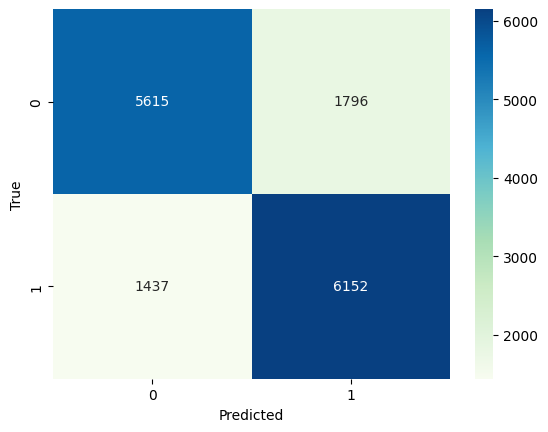

In [ ]:
matriz_de_confusion(y_test_xgb, y_pred_xgb_cv)

Métricas en el conjunto de evaluación del modelo

In [ ]:
metricas_evaluacion(y_test_xgb, y_pred_xgb_cv)

Accuracy: 0.7844666666666666
Recall: 0.8106469890631177
f1 score: 0.7919160713136384


Metricas de test del modelo

In [ ]:
valor_metricas_test(y_test_xgb, y_pred_xgb_cv)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      7411
           1       0.77      0.81      0.79      7589

    accuracy                           0.78     15000
   macro avg       0.79      0.78      0.78     15000
weighted avg       0.78      0.78      0.78     15000



Metricas de train del modelo

In [ ]:
valor_metricas_train(y_train_xgb, x_train_xgb, model_xgb_tfidf_cv)

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     17589
           1       0.88      0.92      0.90     17411

    accuracy                           0.90     35000
   macro avg       0.90      0.90      0.90     35000
weighted avg       0.90      0.90      0.90     35000



Podemos ver que comparando ambas metricas, no hay una diferencia significa para los label positivo y negativo.

Tambien la coincidencia que tomamos es que en el label positivo, ambos tienen mayor valor para recall y f1-score, pero en las metricas de test, tienen mayor registros en el label positivo y en las metricas de train, tienen mayor registro en el label negativo.

Finalmente, comparando ambos f1-score, no hay una gran diferencia asi que no los consideramos overfiteado.


## Random Forest

Matriz de confusion del modelo

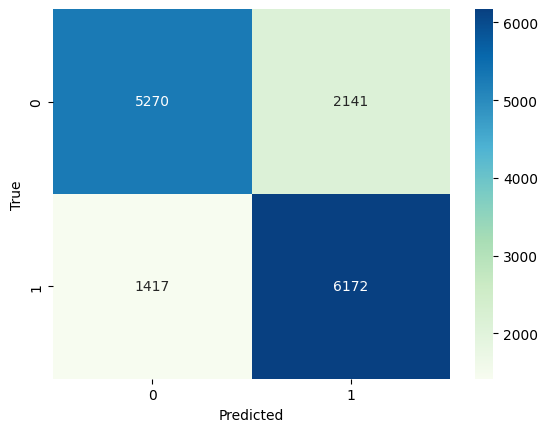

In [ ]:
matriz_de_confusion(y_test_rf, y_pred_rf_cv)

Métricas en el conjunto de evaluación del modelo

In [ ]:
metricas_evaluacion(y_test_rf, y_pred_rf_cv)

Accuracy: 0.7628
Recall: 0.8132823823955725
f1 score: 0.7762545591749466


Metricas de test del modelo

In [ ]:
valor_metricas_test(y_test_rf, y_pred_rf_cv)

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      7411
           1       0.74      0.81      0.78      7589

    accuracy                           0.76     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.77      0.76      0.76     15000



Metricas de train del modelo

In [ ]:
valor_metricas_train(y_train_rf, x_train_rf, model_rf_tfidf_cv)

              precision    recall  f1-score   support

           0       0.92      0.80      0.85     17589
           1       0.82      0.93      0.87     17411

    accuracy                           0.86     35000
   macro avg       0.87      0.86      0.86     35000
weighted avg       0.87      0.86      0.86     35000



nuevamente, podemos que no hay gran diferencia entre ambas metricas, para los labels positivo y negativo.

Las diferencias que encontramos es que donde hay mayor aporte de registros en el negativo es en las metricas de train y en las metricas de test, hay mayor aporte de registros de positivo. Tambien, coincide como en el caso de XGBOOST, que para recall y f1-score, hay mayor valor en el label positivo.

Por ultimo, por la leve diferencia que muestran ambas metricas, consideramos al modelo no overfiteado

## Redes neuronales

In [ ]:
y_pred_mod_1 = model_RNN.predict(test_padded_sequences)
y_pred_mod_1_cat = np.where(y_pred_mod_1 > 0.5,1,0)

313/313 [==============================] - 0s 815us/step


In [ ]:
array_unidimensional = y_pred_mod_1_cat.flatten()
array_unidimensional

array([0, 0, 1, ..., 1, 1, 1])

Matriz de confusion del modelo

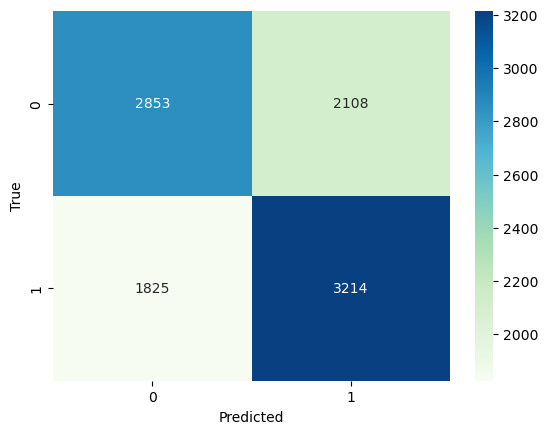

In [ ]:
matriz_de_confusion(y_test, array_unidimensional)

Métricas en el conjunto de evaluación del modelo

In [ ]:
y_test_cast = tf.cast(y_test, tf.float32)
y_pred_mod_1_cat_cast = tf.cast(array_unidimensional, tf.float32)

accuracy = accuracy_score(y_test_cast, y_pred_mod_1_cat_cast)
recall = recall_score(y_test_cast, y_pred_mod_1_cat_cast)
f1_result = f1_score(y_test_cast, y_pred_mod_1_cat_cast)

print("Accuracy: "+ str(accuracy))
print("Recall: "+ str(recall))
print("f1 score: "+ str(f1_result))

Accuracy: 0.6067
Recall: 0.6378249652708871
f1 score: tf.Tensor(0.62040335, shape=(), dtype=float32)


Metricas de test del modelo

In [ ]:
valor_metricas_test(y_test, array_unidimensional)

              precision    recall  f1-score   support

           0       0.61      0.58      0.59      4961
           1       0.60      0.64      0.62      5039

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



Metricas de train del modelo

In [ ]:
print(classification_report(y_train, np.where((model_RNN.predict(train_padded_sequences)) > 0.5,1,0)))

1250/1250 [==============================] - 1s 891us/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     20039
           1       0.78      0.81      0.79     19961

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



En ambas metricas, el recall es el que tiene mayor valor en el label positivo, pero en el label negativo, es la precision.

Podemos ver que en Test, hay mayor aporte de registros en el label positivo pero en el train, hay mayor aporte de registros , label negativo.

Finalmente, por tener una clara diferencia entre ambas metricas, y como el train esta mas alto, consideramos a la red neuronal como overfiteada

## Ensamble Hibrido Voting

Matriz de confusion del modelo

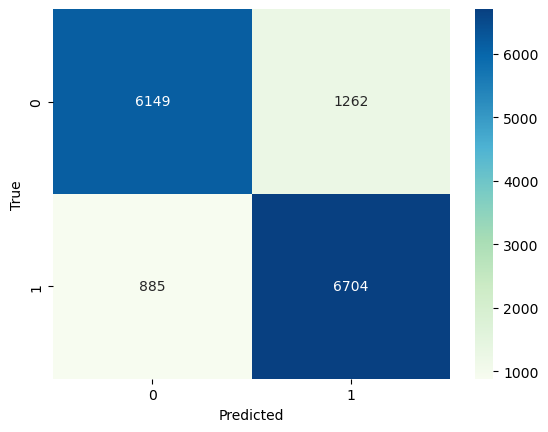

In [ ]:
matriz_de_confusion(y_test_voting, y_pred_voting)

Métricas en el conjunto de evaluación del modelo

In [ ]:
metricas_evaluacion(y_test_voting, y_pred_voting)

Accuracy: 0.8568666666666667
Recall: 0.883383845038872
f1 score: 0.8619736419157827


Metricas de test del modelo

In [ ]:
valor_metricas_test(y_test_voting, y_pred_voting)

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      7411
           1       0.84      0.88      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



Metricas de train del modelo

In [ ]:
valor_metricas_train(y_train_voting, x_train_tfidf_voting, vot_clf)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     17589
           1       0.98      0.99      0.98     17411

    accuracy                           0.98     35000
   macro avg       0.98      0.98      0.98     35000
weighted avg       0.98      0.98      0.98     35000



nuevamente, podemos que no hay gran diferencia entre ambas metricas, para los labels positivo y negativo.

Las diferencias que encontramos es que donde hay mayor aporte de registros en el negativo es en las metricas de train y en las metricas de test, hay mayor aporte de registros de positivo. Tambien, coincide que recall es el de mayor valor para el label positivo

Por ultimo, por la leve diferencia que muestran ambas metricas, consideramos al modelo no overfiteado


# Submission y exportacion de modelos

Realizamos preprocesamiento sobre el conjunto de test, para realizar una submission con él

In [ ]:
ds_test['review_es'] = [eliminar_caracteres_especiales(reseña) for reseña in ds_test['review_es']]
ds_test['review_es'] = [convertir_a_minuscula(reseña) for reseña in ds_test['review_es']]
ds_test['review_es'] = [remover_stopwords(oracion, 'spanish') for oracion in ds_test['review_es']]
ds_test['review_es'] = [remover_stopwords(oracion, 'english') for oracion in ds_test['review_es']]

Exportamos cada modelo con mejor performance, sacamos la prediccion con el dataset test y posteriormente, guardamos la submission para la subida a Kaggle.

## Bayes Naive

In [ ]:
import joblib

joblib.dump(model_multinomial_tfidf_cv, '/content/drive/MyDrive/TP2_Orga/clasificador_bayes_naive')

['/content/drive/MyDrive/TP2_Orga/clasificador_bayes_naive']

In [ ]:
y_pred_bayes_submission = model_multinomial_tfidf_cv.predict(ds_test['review_es'])

ds_test_id = ds_test['ID'].copy()
df_submission_bayes = pd.DataFrame({'ID': ds_test_id, target: y_pred_bayes_submission})

df_submission_bayes.to_csv('/content/drive/MyDrive/TP2_Orga/submissions/submission_bayes_tfidf_multinomialnb_cv_28_6.csv', index = False)

## XGBoost

In [ ]:
import joblib

joblib.dump(model_xgb_tfidf_cv, '/content/drive/MyDrive/TP2_Orga/clasificador_xgboost')

In [ ]:
y_pred_xgboost_tfidf = model_xgb_tfidf_cv.best_estimator_.predict(ds_test['review_es'])

predicted_labels = label_encoder.inverse_transform(y_pred_xgboost_tfidf)

df_submission_red = pd.DataFrame({'ID': ds_test['ID'], target: predicted_labels})

df_submission_red.to_csv('/content/drive/MyDrive/TP2_Orga/submissions/submission_xgboost_tfidf_cv_28_06.csv', index = False)

## Random Forest

In [ ]:
import joblib

joblib.dump(model_rf_tfidf_cv, '/content/drive/MyDrive/TP2_Orga/clasificador_rf')

['/content/drive/MyDrive/TP2_Orga/clasificador_rf']

In [ ]:

y_pred_rf_tfidf = model_rf_tfidf_cv.best_estimator_.predict(ds_test['review_es'])

predicted_labels = label_encoder.inverse_transform(y_pred_rf_tfidf)

ds_test_id = ds_test['ID'].copy()
df_submission_rf = pd.DataFrame({'ID': ds_test_id, target: predicted_labels})

df_submission_rf.to_csv('/content/drive/MyDrive/TP2_Orga/submissions/submission_RF_TFIDF_optimizado_28_6_8.csv', index = False)

## Redes Neuronales

In [ ]:
import joblib

joblib.dump(model_RNN, 'clasificador_red_neuronal_RNN')

['clasificador_red_neuronal_RNN']

In [ ]:
tokenized_textos = [word_tokenize(texto) for texto in ds_test['review_es']]

vocabulario = set(word for texto in tokenized_textos for word in texto)
vocabulario_size = len(vocabulario)

word_to_index = {word: index for index, word in enumerate(vocabulario)}

encoded_test_textos = [[word_to_index[word] for word in texto] for texto in tokenized_textos]
padded_test_textos = np.array([texto[:max_sequence_length] + [0] * (max_sequence_length - len(texto[:max_sequence_length])) for texto in encoded_test_textos])

y_pred_mod_1 = model_RNN.predict(padded_test_textos)
y_pred_mod_1_cat = np.where(y_pred_mod_1 > 0.4,1,0)

In [ ]:
predicted_labels = label_encoder.inverse_transform(y_pred_mod_1_cat)

In [ ]:
df_submission_red = pd.DataFrame({'ID': ds_test['ID'], 'sentimiento': predicted_labels})

df_submission_red.to_csv('/content/drive/MyDrive/TP2_Orga/submissions/submission_red_neuronal_lstm_25_6_1.csv', index = False)

## Ensamble Hibrido Voting

In [ ]:
import joblib

joblib.dump(model_voting, 'clasificador_voting')

['clasificador_voting']

In [ ]:
x_test = tfidfVectorizer.transform(ds_test['review_es'])
y_pred_voting_tfidf = model_voting.predict(x_test)

predicted_labels = label_encoder.inverse_transform(y_pred_voting_tfidf)

ds_test_id = ds_test['ID'].copy()
df_submission_rf = pd.DataFrame({'ID': ds_test_id, target: predicted_labels})

df_submission_rf.to_csv('/content/drive/MyDrive/TP2_Orga/submissions/submission_VOTING_optimizado_28_6_8.csv', index = False)